# ***XGBoost Models***

İkinci proje olan regresyon projesinde kullandığınız veri kümesini tekrar kullanarak ***XGBoost*** algoritmasını kullanarak regresyon ve sınıflandırma modelleri oluşturun ve bu model için en uygun parametre değerlerini belirleyin. Projelerinizdeki modellerle karşılaştırın.

---

## ***Classification - Titanic***

- Siniflandirma projesinde Titanic verileriyle calismistik, burada da ayni veri setiyle calisacagiz.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
# metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# cross validation
from sklearn.model_selection import cross_validate
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# hiperparametre tuning icin
from sklearn.model_selection import GridSearchCV

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

# veri setini dataframe icerisine yukle
titanic = pd.read_csv('data/titanic_train.csv')

### ***Veri Kesfi***
- Veri setini inceleme.

In [62]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Cabin, Ticket degiskenleri numerik olmadigindan ve burada ihtiyacimiz olmadigindan cikarabiliriz.

In [63]:
titanic = titanic.drop(['Cabin','Ticket'], axis=1)
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked'],
      dtype='object')

In [64]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- Embarked 3 farkli deger almis, eksik veriler en sik karsilasilan degerle doldurulabilir.

In [65]:
titanic['Embarked'].fillna('S', inplace=True)

- Son olarak yas degeri de ortalama deger ile dolduruldu.

In [66]:
titanic['Age'].fillna(np.floor(titanic['Age'].mean()), inplace=True)

In [67]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


***Cinsiyet ve Liman bilgisi encode edilerek dahil edildi***

In [68]:
# get_dummies metodu ile encode edilir
titanic = pd.concat([titanic, pd.get_dummies(titanic.Sex, 
                                             drop_first=True)], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic.Embarked, 
                                             drop_first=True, prefix='Embarked')], axis=1)
# encode edilen sutunlar drop edilir
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [69]:
def add_title(col):
    if 'Mrs' in col:
        return 'mrs'
    elif 'Master' in col:
        return 'master'
    elif 'Mr' in col:
        return 'mr'
    elif 'Miss' in col:
        return 'miss'
    else:
        return 'no_title'

In [70]:
titanic['title'] = titanic['Name'].apply(add_title)

In [71]:
titanic['title'].unique()

array(['mr', 'mrs', 'miss', 'master', 'no_title'], dtype=object)

In [72]:
titanic = pd.concat([titanic,pd.get_dummies(titanic['title'])], axis=1)

In [73]:
titanic

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,title,master,miss,mr,mrs,no_title
0,1,0,3,"Braund, Mr. Owen Harris",22.000,1,0,7.250,1,0,1,mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.000,1,0,71.283,0,0,0,mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000,0,0,7.925,0,0,1,miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,53.100,0,0,1,mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.000,0,0,8.050,1,0,1,mr,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.000,0,0,13.000,1,0,1,no_title,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.000,0,0,30.000,0,0,1,miss,0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",29.000,1,2,23.450,0,0,1,miss,0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",26.000,0,0,30.000,1,0,0,mr,0,0,1,0,0


In [74]:
titanic.drop(['Name', 'title', 'no_title'], axis=1, inplace=True)

In [75]:
titanic

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,master,miss,mr,mrs
0,1,0,3,22.000,1,0,7.250,1,0,1,0,0,1,0
1,2,1,1,38.000,1,0,71.283,0,0,0,0,0,0,1
2,3,1,3,26.000,0,0,7.925,0,0,1,0,1,0,0
3,4,1,1,35.000,1,0,53.100,0,0,1,0,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000,0,0,13.000,1,0,1,0,0,0,0
887,888,1,1,19.000,0,0,30.000,0,0,1,0,1,0,0
888,889,0,3,29.000,1,2,23.450,0,0,1,0,1,0,0
889,890,1,1,26.000,0,0,30.000,1,0,0,0,0,1,0


### ***XGBoost siniflandirma modeli***

- XGBoost Python API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

***Dmatrix donusumu***
- xgboost performans ve etkinligini dmatrix veri yapisindan alir.

In [76]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = titanic.drop(['Survived', 'PassengerId'], axis=1)
y = titanic['Survived']

# dmatrix donusturme, xgboost performans ve etkinligini bu veri yapisindan alir
titanic_dmatrix = xgb.DMatrix(data=X, label=y)

In [ ]:
dir(xgb)

***Parametre belirleme***
- Modelimizi oluşturuken kullancağımız parametreleri belirliyoruz. 

- ```objective``` paramatresi XGBoost parametreleri içinde en önemlilerinden bir tanesidir. 
    - Bu parametre ile modelimizin hata fonksiyonu olarak ne kullanacağını belirtiyoruz.
    - Regresyon modellerinde ```reg:linear, reg:squarederror``` kullanilir.
    - Sınıflandırma modellerinde ise, tahmin edilen sınıf için ```reg:logistic```, tahmin ihtimali için ise ```binary:logistic``` ifadesi kullanılır.
    - ```'verbosity':0``` ya da ```'silent':1``` parametreleriyle uyari vermesini engelleriz.

In [77]:
# objective parametesi ile hangi fonksiyonu hata fonksiyonu olarak kullancagimizi belirleriz
params = {"objective":"reg:logistic", "max_depth":3, "silent":1}

### ***Cross Validation - xgboost.cv metodu ile***

- ```cv``` metodu hakkinda bilgi icin XGBoost Learning API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)

- XGBoost'un içerisinde gömülü çapraz doğrulama (cross-validation) imkanı olduğundan modelin sonuçlarını çapraz doğrulama yaparak alabiliriz.

- ```xgb.cv``` fonksiyonunda:
    - ```metrics=error``` parametresi ile değerlendirme metriği olarak hata oranı tanımlandi. 
    - ```as_pandas=True``` parametresi ile test ve eğitim verileri için hata oranını ve hata oranının standart sapmasını veri çerçevesi olarak döndü. 
- Hata değerini 1'den çıkararak doğruluk (accuracy) değerini bulabiliriz.

In [78]:
# xgboost icersindeki gomulu capraz dogrulama metodunu kullandik
# metrics=error parametresi ile değerlendirme metriği olarak hata oranı tanımladik 
# as_pandas=True parametresi ile test ve eğitim verileri için 
# hata oranını ve hata oranının standart sapmasını veri çerçevesi olarak döndü
titanic_cv = xgb.cv(dtrain=titanic_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="error", as_pandas=True, seed=123)
display(titanic_cv)

# hata değerini 1'den çıkararak doğruluk değerini bulduk
print('Doğruluk Değeri : {:.3f}'.format((1-titanic_cv["test-error-mean"]).max()))

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.168,0.010,0.192,0.021
1,0.160,0.017,0.193,0.012
2,0.156,0.014,0.190,0.014
3,0.150,0.016,0.185,0.012
4,0.149,0.014,0.190,0.011


Doğruluk Değeri : 0.815


***Performans degerlendirmesi***
- AUC skoru ile değerlendirebiliriz.

In [79]:
# model performansini auc skoru ile degerlendirdik
titanic_auc = xgb.cv(dtrain=titanic_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics="auc", as_pandas=True, seed=123)
display(titanic_auc)
print('AUC Skoru : {:.3f}'.format(titanic_auc["test-auc-mean"].max()))

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.870,0.008,0.852,0.045
1,0.880,0.010,0.857,0.035
2,0.884,0.010,0.855,0.037
3,0.889,0.012,0.855,0.036
4,0.894,0.012,0.857,0.035


AUC Skoru : 0.857


***Birden fazla metric degeri ile cross validation***

In [80]:
# model performansini auc skoru ile degerlendirdik
titanic_auc = xgb.cv(dtrain=titanic_dmatrix, params=params, nfold=3, 
                    num_boost_round=5, metrics=("auc",'error'), as_pandas=True, seed=123)
display(titanic_auc)
print('AUC Skoru : {:.3f}'.format(titanic_auc["test-auc-mean"].max()))
print('Dogruluk Skoru : {:.3f}'.format((1-titanic_cv["test-error-mean"]).max()))

,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.870,0.008,0.168,0.010,0.852,0.045,0.192,0.021
1,0.880,0.010,0.160,0.017,0.857,0.035,0.193,0.012
2,0.884,0.010,0.156,0.014,0.855,0.037,0.190,0.014
3,0.889,0.012,0.150,0.016,0.855,0.036,0.185,0.012
4,0.894,0.012,0.149,0.014,0.857,0.035,0.190,0.011


AUC Skoru : 0.857
Dogruluk Skoru : 0.815


***NOT***

- XGBoost icerisinde scikitlearn API haricinde .fit ve .predict metodlarini kullanamiyoruz.

In [125]:
# asagidaki gibi bir kullanim hata vermektedir
# y_pred = xgb.predict(X_test)

### ***Cross Validation - scikit-learn cross_validation metodu ile***
- Cross validation scikit-learn kutuphanesinin bir metodu oldugundan bu yontemi kullanmak icin scikit-learn API icin olusturulmus ```XGBClassifier``` ile model olusturmaliyiz.

- XGBoost Scikit-learn API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

#### ***scikitlearn API XGBClassifier model***

In [122]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = titanic.drop(['Survived', 'PassengerId'], axis=1)
y = titanic['Survived']

# veri kumesini egitim ve test kumesi olarak ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)

# xgboost siniflandirma modeli; objective paramatresini reg:logistic olarak belirttik
xgb_cl = xgb.XGBClassifier(objective ='reg:logistic', max_depth=3)

# modelimizi train verileri ile fit ettikten sonra 
# test verileri skoruna bakabiliriz
xgb_cl.fit(X_train, y_train)
xgb_cl.score(X_test, y_test)

0.8212290502793296

In [124]:
# modeli nesnesi tekrar olusturulur, cross validate modeli kendi icinde egitir
xgb_cl = xgb.XGBClassifier(objective ='reg:logistic', max_depth=3)
cv = cross_validate(estimator=xgb_cl, X=X, y=y,
                    cv=10, scoring = ['roc_auc', 'f1'])

print('auc scores mean     : ', cv['test_roc_auc'].mean(), sep = '\n')
print("-"*30)
print('f1 scores mean      : ', cv['test_f1'].mean(), sep = '\n')
print("-"*30)

auc scores mean     : 
0.8721651246357128
------------------------------
f1 scores mean      : 
0.7662200610678153
------------------------------


In [119]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### ***Grid Search ile Hiperparametre Ayarlama***

In [128]:
# modeli nesnesi tekrar olusturulur, grid search modeli kendi icinde egitir
xgb_cl = xgb.XGBClassifier(objective ='reg:logistic')
# model hangi parametreleri aliyor incele
print(xgb_cl.get_params())

{'objective': 'reg:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


- ```gamma```  : ağaçların bölünmesi esnasında izin verilen maksimum kayıp azalması, büyük değerler olduğu takdirde daha az dallanma olacaktır.
- ```reg_alpha``` : dalların ağırlıklarının l1(lasso) regularizasyonu, büyük değerler daha fazla regularizasyon anlamına gelmektedir. Bu durumda bir çok ağacın ağırlığı 0 olmaktadır.
- ```reg_lambda``` : dalların ağırlıklarının l2(ridge) regularizasyonu. l1 regularizasyonuna göre daha yumuşaktır.
- ```max_depth``` : her bir ağaç için maksimum derinlik.
- ```subsample``` : modeldeki verilerin bir ağacın eğitimi için kullanılacak oranı. 0 ila 1 arasında bir değerdir. Büyük değerler overfittinge yol açabilir.

- ```colsample_bytree``` : her ağaç için kullanılacak değişken oranı. Bir regularizasyon sayılabilir. Büyük değerler fazla değişkenli modellerden dolayı overfittinge yol açabilir.

- ```min_child_weight``` : bir dalın minimum ağırlık değeri. Düşük değerler underfittinge yol açabilir.


In [131]:
# gamma  Ağaçların bölünmesi esnasında izin verilen maksimum kayıp azalması. 
# Büyük değerler olduğu takdirde daha az dallanma olacaktır.
parameters = {'gamma': [x for x in np.arange(0.01,0.1,0.01)], 
              'reg_alpha': [x for x in np.arange(0.01,0.1,0.01)], 
              'reg_lambda': [x for x in np.arange(0.01,0.1,0.01)],
              'max_depth': [x for x in range(2,10)]
             }
grid_cv = GridSearchCV(estimator=xgb_cl, param_grid = parameters, 
                       cv = 10, scoring='roc_auc', n_jobs=6)
grid_cv.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_esti...
                                   0.060000000000000005, 0.06999999999999999,
                                   0.08, 0.09],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'reg_alpha': [0.01, 0.02, 0.03, 0.04, 0.05,
                        

In [132]:
print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'gamma': 0.09, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.060000000000000005}
En iyi skor         :  0.8770488922841864


---

## ***Regression - House Prices***

- Regresyon projesinde House Prices verileriyle calismistik, burada da ayni veri setiyle calisacagiz.
- Temizlenmis ve aykiri degerlerden arindirilmis veri setiyle model olusturacagiz.

In [11]:
# temiz veri setini dataframe icerisine yukle
house_prices = pd.read_csv('data/house_prices_out.csv', index_col='Id')

In [12]:
house_prices

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,"2,003.000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.000,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,"1,999.000",RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000
1457,20,RL,85.000,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.000,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,"1,978.000",Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1458,70,RL,66.000,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.000,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,"1,941.000",RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500


- Numerik olmayan degiskenler de encode edilerek numerik hale getirilir.

In [13]:
# kategorik degiskenleri encode eden fonksiyon
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o

In [14]:
# object tipinde olanlari ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olmayanlari ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')
expl_vars = []
expl_vars = quantitative + qual_encoded

print('Min satis fiyati : {}\nMax satis fiyati : {}'.format(house_prices['SalePrice'].min(),
                                                            house_prices['SalePrice'].max()))

print('Aciklayici degisken adedi : {}'.format(len(expl_vars)))

Min satis fiyati : 34900
Max satis fiyati : 485000
Aciklayici degisken adedi : 79


### ***XGBoost regresyon modeli***

- Veri kümesini eğitim ve test olarak ayırarak regresyon modelini oluşturacağız. Bu yöntemi kullandığımızda veriler DMatrix veri yapısına çevirmemize gerek kalmayacak.
- Modelin performansını daha önceki makine öğrenme modellerinde yaptığımız gibi ölçebiliriz.
- XGBoost Scikit-learn API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [15]:
# aciklayici degiskenler ve hdef degisken tanimlamasi
X = house_prices[expl_vars]
y = house_prices['SalePrice']

# veri kumesini egitim ve test kumesi olarak ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)
# xgboost lineer regresyon modeli; objective paramatresini reg:linear olarak belirttik
xg_reg = xgb.XGBRegressor(objective ='reg:linear', verbosity=0, seed=123)

# modelimizi train verileri ile fit ettikten sonra 
# test verileri skoruna bakabiliriz
xg_reg.fit(X_train, y_train)
xg_reg.score(X_test, y_test)

0.8929938859718658

### ***RMSE Score***

In [40]:
# rmse hesaplamak icin belirli X verileri icin tahmin degerleri uretmeliyiz
y_pred = xg_reg.predict(X_test)
mse_xg = MSE(y_test, y_pred)
rmse_xg = mse_xg**(1/2)

# Print rmse
print("XGB RMSE score : {:.2f}".format(rmse_xg))

XGB RMSE score : 21555.23


### ***Booster (zayıf öğrenici) degisikligi***

- XGBoost zayıf öğrenici (booster) olarak varsayılanda karar ağaçlarını kullandığından ```booster="gbtree"``` varsayılan parametre olarak belirlenmiştir. 
- ```booster:"gblinear"``` parametresi ile booster olarak lineer model kullanabiliriz.

- XGBoost'ta çok kullanılmasa da karar ağacı yerine lineer model kullanmak istersek booster:"gblinear" şeklinde belirtebiliriz. 

- Karar ağacı yerine lineer model kullanmak çok yaygın olmadığından bu yontemde sklearn API kullanılamamakta. ```DMatrix``` veri yapısını kullanmamız gerekecek.

- ```train``` metodu hakkinda bilgi icin XGBoost Learning API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)

In [41]:
DM_train = xgb.DMatrix(data = X_train, label=y_train)
DM_test =  xgb.DMatrix(data = X_test, label=y_test)
params = {"booster":"gblinear", "objective":"reg:linear", 'verbosity': 0}
xg_reg = xgb.train(dtrain=DM_train, params=params, num_boost_round=5)

In [42]:
y_pred_gblinear = xg_reg.predict(DM_test)
rmse = np.sqrt(MSE(y_test, y_pred_gblinear))
print("RMSE: %f" % (rmse))

RMSE: 283033137.585015


- Rmse skorlarinda asiri fark gozlendi. gblinear modelin performansi cok dusuk.
- gbtree ve gblinear karsilastirma grafigi asagidadir.

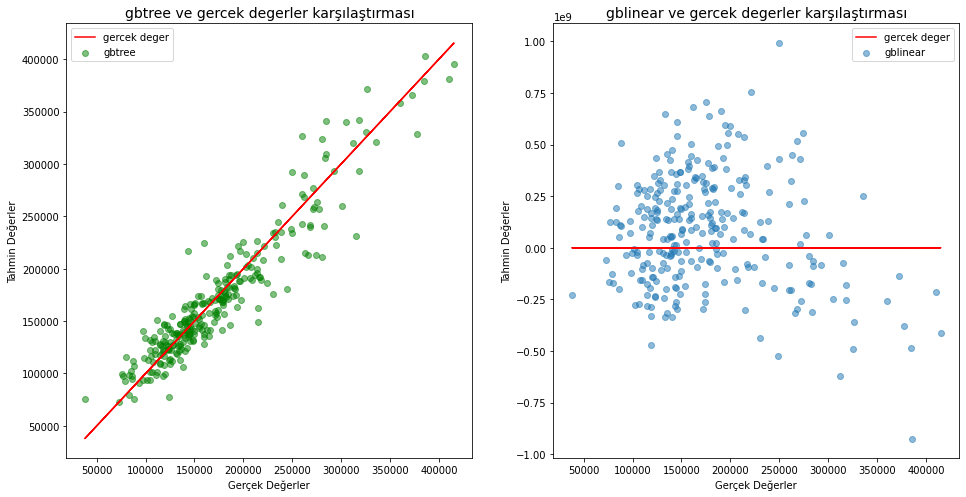

In [43]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title("gbtree ve gercek degerler karşılaştırması", size = 14)
ax1 = plt.scatter(y_test, y_pred, alpha=0.50, c='green')
ax3 = plt.plot(y_test, y_test, color="red")
plt.legend(['gercek deger', 'gbtree'])
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerler")

plt.subplot(122)
plt.title("gblinear ve gercek degerler karşılaştırması", size = 14)
ax2 = plt.scatter(y_test, y_pred_gblinear, alpha=0.50)
ax3 = plt.plot(y_test, y_test, color="red")
plt.legend(['gercek deger', 'gblinear'])
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Değerler")

plt.show()

### ***Cross Validation - xgboost.cv metodu ile***

- Çapraz doğrulama için XGBoost'un içerisinde yer alan ```cv``` fonksiyonunu kullanabileceğimiz gibi sklearn içerisinde yer alan ```cross_validation``` fonksiyonunu da kullanabiliriz.

- ```cv``` metodu hakkinda bilgi icin XGBoost Learning API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)

In [16]:
house_prices_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":4, "silent":1}
house_prices_cv = xgb.cv(dtrain=house_prices_dmatrix, params=params, nfold=4,
                         num_boost_round=100, early_stopping_rounds=5, metrics="rmse", 
                         as_pandas=True, seed=123)
display(house_prices_cv.sort_values(by='test-rmse-mean').head(5))

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
44,"7,990.909",87.741,"21,249.878","1,354.223"
43,"8,119.244",76.016,"21,251.643","1,336.869"
42,"8,231.016",88.770,"21,255.773","1,355.439"
41,"8,351.323",111.623,"21,269.655","1,381.796"
39,"8,532.752",110.604,"21,279.753","1,393.678"


- RMSE değeri 45. iterasyonda 21249'a indi.

### ***Cross Validation - scikit-learn cross_validation metodu ile***
- Cross validation scikit-learn kutuphanesinin bir metodu oldugundan bu yontemi kullanmak icin scikit-learn API icin olusturulmus ```XGBRegressor``` ile model olusturmaliyiz.

- XGBoost Scikit-learn API [dokumantasyon](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

#### ***scikitlearn API XGBRegressor model***

In [164]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = house_prices[expl_vars]
y = house_prices['SalePrice']

# veri kumesini egitim ve test kumesi olarak ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)
# xgboost lineer regresyon modeli; objective paramatresini reg:linear olarak belirttik
xgb_reg = xgb.XGBRegressor(objective ='reg:linear')

# modelimizi train verileri ile fit ettikten sonra 
# test verileri skoruna bakabiliriz
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)

0.8929938859718658

#### ***cross_validate***

In [173]:
# modeli nesnesi tekrar olusturulur, cross validate modeli kendi icinde egitir
xgb_reg = xgb.XGBRegressor(objective ='reg:linear')
cv = cross_validate(estimator=xgb_reg, X=X, y=y,
                    cv=10, scoring = ['neg_root_mean_squared_error', 'r2'])

print('rmse scores mean : ', 
          -cv['test_neg_root_mean_squared_error'].mean(), sep = '\n')
print('r2 scores mean       : ', 
      cv['test_r2'].mean(), sep = '\n')

rmse scores mean : 
21418.946336267843
r2 scores mean       : 
0.8997464573681496


### ***Hiperparametre Ayarlama - xgboost.cv ile***

In [47]:
# aciklayici degiskenler ve hedef degisken tanimlamasi
X = house_prices[expl_vars]
y = house_prices['SalePrice']
# xgboost dmatrix veri yapisina donusturme
house_prices_dmatrix = xgb.DMatrix(data=X, label=y)
# parametre range belirleme
l1_params = np.arange(0.01, 0.1, 0.01)
l2_params = np.arange(0.01, 0.1, 0.01)
gamma_params = np.arange(0.01, 0.1, 0.01)
max_depth_params = range(2,10)
# temel parametreler
params = {"objective":"reg:linear", "silent":1}
# en iyi rmse ve hiperparametreleri tutacak degiskenler
best_rmse = 30000
best_l1, best_l2, best_gamma, best_max_depth = (0,0,0,0) 

for alpha in l1_params:
    params["alpha"] = alpha
    for lambd in l2_params:
        params["lambda"] = lambd
        for gamma in gamma_params:
            params["gamma"] = gamma
            for max_depth in max_depth_params:
                params["max_depth"] = max_depth
                cv_rmse = xgb.cv(dtrain=house_prices_dmatrix, params=params, nfold=4, num_boost_round=100, 
                                         metrics="rmse", as_pandas=True, early_stopping_rounds=10, seed=123)
                iter_rmse = house_prices_cv['test-rmse-mean'].sort_values().head(1).values[0]
                if  iter_rmse < best_rmse:
                    best_rmse = iter_rmse
                    best_l1, best_l2, best_gamma, best_max_depth = alpha, lambd, gamma, max_depth


print("En iyi parametreler : \nl1: {}\nl2: {}\ngamma: {}\nmax_depth :{}".format(
    best_l1, best_l2, best_gamma, best_max_depth))
print("En iyi rmse         : ", best_rmse)

En iyi parametreler : 
l1: 0.01
l2: 0.01
gamma: 0.01
max_depth 2
En iyi rmse         :  21249.87744125


### ***Hiperparametre Ayarlama - Grid Search ile***

In [37]:
# modeli nesnesi tekrar olusturulur, grid search modeli kendi icinde egitir
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', verbosity=0)
# model hangi parametreleri aliyor incele
print(xgb_reg.get_params())

{'objective': 'reg:linear', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': False, 'verbosity': 0}


In [9]:
parameters = {'gamma': [x for x in np.arange(0.01,0.1,0.01)], 
              'reg_alpha': [x for x in np.arange(0.01,0.1,0.01)], 
              'reg_lambda': [x for x in np.arange(0.01,0.1,0.01)],
              'max_depth': [x for x in range(2,10)]
             }
grid_cv = GridSearchCV(estimator=xgb_reg, param_grid = parameters, 
                       cv = 10, scoring='neg_root_mean_squared_error', n_jobs=6)
grid_cv.fit(X, y)

print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'gamma': 0.01, 'max_depth': 3, 'reg_alpha': 0.09, 'reg_lambda': 0.03}
En iyi skor         :  -19676.262758389697


- ***???*** Grid Search daha iyi sonuc verdi, ayni sonuclari elde etmemiz bekleniyordu, ```cv``` metodundaki ```early_stopping_rounds``` parametresinden kaynaklaniyor olabilir. GridSearch de bu parametreyi girdi olarak veremiyoruz. Ancak estimator un fit metodu bu parametreyi aliyor bir de oyle denenebilir. [Stackoverflow](https://stackoverflow.com/questions/42993550/gridsearchcv-xgboost-early-stopping) incelenebilir.